In [3]:
import pandas as pd
import shutil
import os
import pydicom as dicom
import matplotlib.pyplot as plt
import multiprocessing
import hashlib

In [6]:
ORIGINAL_DATASET_DIR = "../manifest-ZkhPvrLo5216730872708713142"
DEST_DIR = "../cbis-ddsm"

In [7]:
def calc_md5(img):
    md5hash = hashlib.md5(img.tobytes())
    return md5hash.hexdigest()

def convert_filename(file_path: str):
    path_parts = file_path.split("/")
    file_name = path_parts[-1]
    file_name_parts = file_name.split(".")
    name = int(file_name_parts[0])
    result = "/".join(path_parts[:-1]) + "/1-" + str(name + 1) + "." + file_name_parts[-1]

    return result.strip()

def generate_filename(row, type):
    dir = f'{row.dataset}/{row["abnormality_type"]}/{row["patient_id"]}_{row["left_or_right_breast"]}_{row["image_view"]}_{row["abnormality_id"]}'
    return dir + "_" + type + ".dcm"

def format_metadata(df: pd.DataFrame, dataset_type):
    df.rename(columns={"mass shape": "shape"}, inplace=True)
    df.rename(columns={"mass margins": "margin"}, inplace=True)

    df.columns = [col.replace(" ", "_").lower() for col in df.columns]
    metadata = df

    metadata['dataset'] = dataset_type

    return metadata

train_mass_metadata = format_metadata(pd.read_csv(f'{ORIGINAL_DATASET_DIR}/mass_case_description_train_set.csv'), "train")
test_mass_metadata = format_metadata(pd.read_csv(f'{ORIGINAL_DATASET_DIR}/mass_case_description_test_set.csv'), "test")

metadata = pd.concat([train_mass_metadata, test_mass_metadata])

print(len(metadata))
metadata.head()

1696


,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,shape,margin,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,roi_mask_file_path,dataset
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,train
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,train
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,train
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,train
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,train


## Restructure files

In [19]:
os.mkdir(DEST_DIR)
os.mkdir(f"{DEST_DIR}/train")
os.mkdir(f"{DEST_DIR}/train/mass")
os.mkdir(f"{DEST_DIR}/test")
os.mkdir(f"{DEST_DIR}/test/mass")

In [20]:
def restructure_file(row):
    i, row = row
    dir = f'{DEST_DIR}/{row.dataset}/{row["abnormality_type"]}/{row["patient_id"]}_{row["left_or_right_breast"]}_{row["image_view"]}_{row["abnormality_id"]}'

    img_original_path = convert_filename(row['image_file_path'])
    img_cropped_path = convert_filename(row['cropped_image_file_path'])
    img_roi_path = convert_filename(row['roi_mask_file_path'])

    original_img = dicom.dcmread(f"{ORIGINAL_DATASET_DIR}/CBIS-DDSM/{img_original_path}")
    cropped_img = dicom.dcmread(f"{ORIGINAL_DATASET_DIR}/CBIS-DDSM/{img_cropped_path}")
    mask_img = dicom.dcmread(f"{ORIGINAL_DATASET_DIR}/CBIS-DDSM/{img_roi_path}")

    shutil.copyfile(f"{ORIGINAL_DATASET_DIR}/CBIS-DDSM/{img_original_path}", f"{dir}_original.dcm")

    if len(cropped_img.pixel_array) > len(mask_img.pixel_array):
        temp = img_cropped_path
        img_cropped_path = img_roi_path
        img_roi_path = temp
    
    shutil.copyfile(f"{ORIGINAL_DATASET_DIR}/CBIS-DDSM/{img_cropped_path}", f"{dir}_cropped.dcm")
    shutil.copyfile(f"{ORIGINAL_DATASET_DIR}/CBIS-DDSM/{img_roi_path}", f"{dir}_mask.dcm")

    return calc_md5(original_img.pixel_array)

In [21]:
with multiprocessing.Pool(16) as pool:
    results = pool.map(restructure_file, metadata.iterrows())
    metadata["checksum"] = results

In [22]:
metadata['image_file_path'] = metadata.apply(lambda row: generate_filename(row, 'original'), axis=1)
metadata['cropped_image_file_path'] = metadata.apply(lambda row: generate_filename(row, 'cropped'), axis=1)
metadata['roi_mask_file_path'] = metadata.apply(lambda row: generate_filename(row, 'mask'), axis=1)

In [25]:
metadata.to_csv(f"{DEST_DIR}/metadata.csv", index=False, header=True)

## Visualize examples

In [46]:
def show_examples(df: pd.DataFrame, amount = 3):
    
    for i, sample in df.sample(n=amount).reset_index().iterrows():

        img_original_path = sample['image_file_path']
        img_cropped_path = sample['cropped_image_file_path']
        img_roi_path = sample['roi_mask_file_path']

        img_original = dicom.dcmread("../cbis-ddsm/" + img_original_path)
        img_roi = dicom.dcmread("../cbis-ddsm/" + img_roi_path)
        img_cropped = dicom.dcmread("../cbis-ddsm/" + img_cropped_path)
        plt.suptitle(sample["pathology"], fontsize=25, y=0.95)
        plt.subplot(amount, 3, i * amount + 1)
        plt.title(f"{sample['abnormality_type']} mammogram".upper())
        plt.imshow(img_original.pixel_array)
        plt.subplot(amount, 3, i * amount + 2)
        plt.title("SEGMENTATION")
        plt.imshow(img_roi.pixel_array)
        plt.subplot(amount, 3, i * amount + 3)
        plt.title("ZOOMED IN AREA")
        plt.imshow(img_cropped.pixel_array)
    
    plt.gcf().set_size_inches(10, 12)
    plt.show()

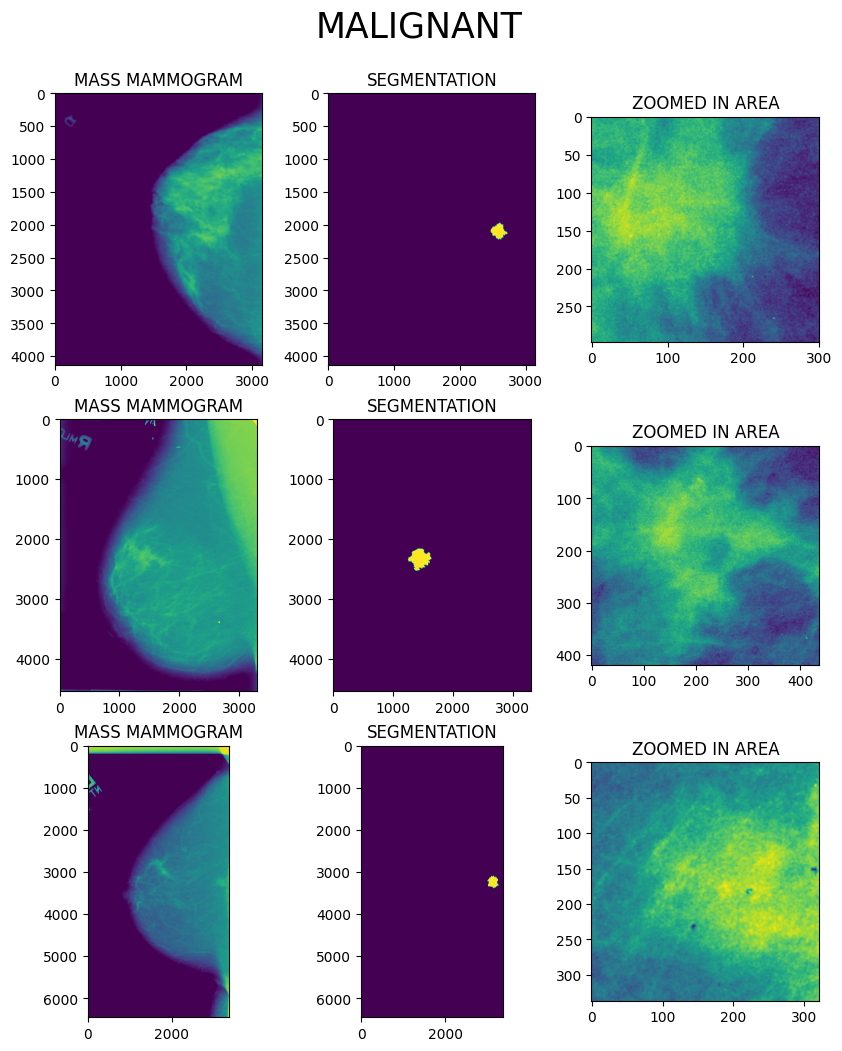

In [47]:
show_examples(metadata.query("pathology == 'MALIGNANT' and abnormality_type == 'mass'"))

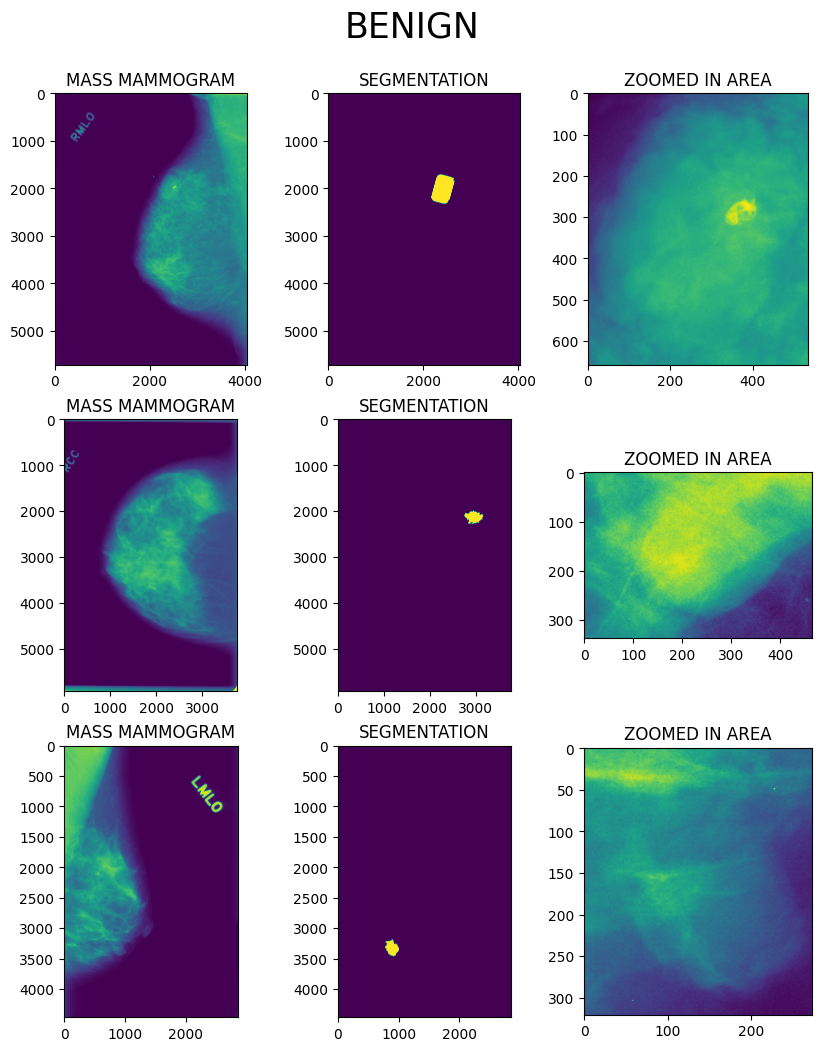

In [48]:
show_examples(metadata.query("pathology == 'BENIGN' and abnormality_type == 'mass'"))

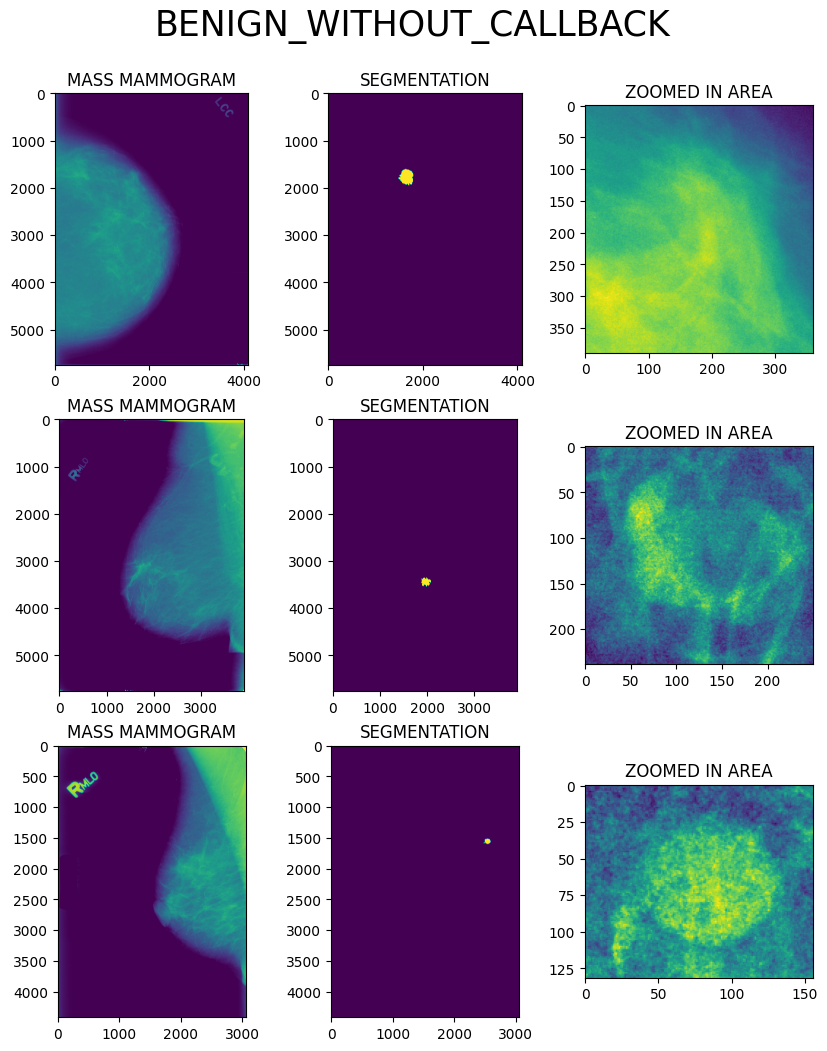

In [49]:
show_examples(metadata.query("pathology == 'BENIGN_WITHOUT_CALLBACK' and abnormality_type == 'mass'"))